# Research Challenge

```{admonition} Margaret Atwood
:class: tip
Every aspect of human technology has a dark side, including the bow and arrow
```

## 🏅 Build your own model 

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture9-challenge). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed. 

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [59]:
import numpy as np

# Insert your values
Name = "Abhi Rajendran" # Replace with your name
CID = 1712516 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Abhi Rajendran [CID: 1712516]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark. 

In [41]:
# Spare cell

#Performing classification on glasses - gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.


## Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [60]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

  # D (GTA - Yifan)
info = get_all_dataset_info("matbench_glass")

# Check out the info about the dataset.
print(info)

Dataset: matbench_glass
Description: Matbench v0.1 test dataset for predicting full bulk metallic glass formation ability from chemical formula. Retrieved from "Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys,’ a volume of the Landolt– Börnstein collection. Deduplicated according to composition, ensuring no compositions were reported as both GFA and not GFA (i.e., all reports agreed on the classification designation). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
Num Entries: 5680
Reference: Y. Kawazoe, T. Masumoto, A.-P. Tsai, J.-Z. Yu, T. Aihara Jr. (1997) Y. Kawazoe, J.-Z. Yu, A.-P. Tsai, T. Masumoto (ed.) SpringerMaterials
Nonequilibrium Phase Diagrams of Ternary Amorphous All

In [61]:
# module imports 
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation with DataFrames
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualisation

# Load dataset into a pandas DataFrame
df = load_dataset("matbench_glass")
df

Reading file /opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/matminer/datasets/matbench_glass.json.gz: 0it [00:00, ?it/s]0, ?it/s]


,composition,gfa
0,Al,False
1,Al(NiB)2,True
2,Al10Co21B19,True
3,Al10Co23B17,True
4,Al10Co27B13,True
...,...,...
5675,ZrTi9,False
5676,ZrTiSi2,True
5677,ZrTiSi3,True
5678,ZrVCo8,True


In [54]:
df.describe()

,composition,gfa,composition_pmg
count,5680,5680,5680
unique,5680,2,5680
top,Al,True,(Al)
freq,1,4035,1


In [77]:
from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core import Composition

class DataProcessor:
    def __init__(self, embedding="magpie"):
        self.embedding = embedding
        self.featuriser = ElementProperty.from_preset(preset_name='magpie')
        self.featuriser.set_n_jobs(1)
    
    def featurise_composition(self, df):
        # Create a copy of the dataframe
        data = df.copy()
        print(f"Using {self.embedding} embedding for composition featurisation.")
        
        onehot_df = composition_featuriser(data["composition"], embedding=self.embedding, stats=["sum"])
        onehot_df.drop(columns=['formula'], inplace=True)  # Drop the original composition column
        
        return onehot_df
    
    def featurise_with_pymatgen(self, df, col_id='composition'):
        df["composition_pmg"] = df[col_id].map(Composition)
        df_pmg = self.featuriser.featurize_dataframe(df, col_id='composition_pmg')
        return df_pmg
    
    def scale_data(self, df):
        # Create a copy of the dataframe
        data = df.copy()
        
        # Scale only columns that are numerical 
        numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Scaling the following columns: {numerical_cols}")

        # Scale numerical columns
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data[numerical_cols])
        
        # Convert the scaled data back to a DataFrame
        #scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols, index=data.index)
        
        return scaled_data

    
    

# Create an instance of the DataProcessor class
data_processor = DataProcessor(embedding="magpie")

# Featurise the composition
featurised_data = data_processor.featurise_with_pymatgen(df)

# Scale the featurised data
scaled_data = data_processor.scale_data(featurised_data)

# Create a copy of the scaled data for further processing
#processed_data = scaled_data.copy()


ElementProperty:  64%|██████▍   | 3624/5680 [00:07<00:04, 500.32it/s]

In [76]:
scaled_data

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.150000,0.0125,0.000000,0.072975,0.000000,0.120000,1.000000,0.60,0.000000,0.946614,...,0.000000,0.000000,0.000000,0.000000,0.991111,0.885714,0.000000,0.960342,0.000000,0.936508
1,0.016667,0.2000,0.294872,0.115235,0.299240,0.013333,0.818182,0.60,0.179104,0.864751,...,0.282089,0.118423,0.270805,0.000000,0.728889,0.885714,0.259912,0.707386,0.275832,0.000000
2,0.016667,0.1875,0.282051,0.115839,0.287417,0.306667,0.772727,0.60,0.223881,0.841452,...,0.733642,0.323387,0.714861,0.733642,0.728889,0.885714,0.259912,0.580480,0.174397,0.444444
3,0.016667,0.1875,0.282051,0.129120,0.289968,0.306667,0.772727,0.60,0.223881,0.832636,...,0.733642,0.354186,0.728947,0.733642,0.728889,0.885714,0.259912,0.592484,0.163458,0.444444
4,0.016667,0.1875,0.282051,0.155684,0.282119,0.306667,0.772727,0.60,0.223881,0.815004,...,0.733642,0.415783,0.728947,0.733642,0.728889,0.885714,0.259912,0.616494,0.136342,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,0.300000,0.3500,0.230769,0.235979,0.099338,0.240000,0.545455,0.02,0.014925,0.475904,...,0.000011,0.000010,0.000004,0.000011,0.853333,0.000000,0.000000,0.628069,0.000000,0.444444
5676,0.166667,0.3500,0.333333,0.216358,0.268273,0.133333,0.545455,0.70,0.522388,0.753764,...,0.000011,0.000003,0.000008,0.000000,0.853333,0.942857,0.145374,0.804924,0.160707,0.968254
5677,0.166667,0.3500,0.333333,0.190700,0.250184,0.133333,0.545455,0.70,0.522388,0.808077,...,0.000011,0.000002,0.000007,0.000000,0.853333,0.942857,0.145374,0.840295,0.154279,0.968254
5678,0.316667,0.3500,0.217949,0.297860,0.074197,0.306667,0.560606,0.30,0.208955,0.669541,...,0.733642,0.615975,0.469531,0.733642,0.853333,1.000000,0.154185,0.665584,0.061361,0.444444


In [58]:
processed_data

,sum_Number,sum_MendeleevNumber,sum_AtomicWeight,sum_MeltingT,sum_Column,sum_Row,sum_CovalentRadius,sum_Electronegativity,sum_NsValence,sum_NpValence,...,sum_NValence,sum_NsUnfilled,sum_NpUnfilled,sum_NdUnfilled,sum_NfUnfilled,sum_NUnfilled,sum_GSvolume_pa,sum_GSbandgap,sum_GSmagmom,sum_SpaceGroupNumber
0,0.000135,0.001241,0.000145,0.000019,0.002566,0.000000,0.000000,0.000506,0.000000,0.001656,...,0.000419,0.0,0.004139,0.000000,0.0,0.003765,0.000958,0.000000,0.000000e+00,0.000435
1,0.009017,0.012245,0.007658,0.015103,0.013299,0.012270,0.011547,0.013841,0.012658,0.004967,...,0.011309,0.0,0.012417,0.005083,0.0,0.014307,0.006331,0.013057,5.921133e-03,0.011407
2,0.104978,0.135399,0.091260,0.166802,0.131591,0.152352,0.147976,0.157029,0.155063,0.048013,...,0.114764,0.0,0.120033,0.080051,0.0,0.156627,0.077716,0.124037,1.616934e-01,0.130265
3,0.110900,0.134241,0.096462,0.164656,0.129725,0.156442,0.150308,0.156488,0.155063,0.044702,...,0.119791,0.0,0.111755,0.087675,0.0,0.153614,0.078660,0.110981,1.770928e-01,0.131051
4,0.122744,0.131924,0.106865,0.160363,0.125992,0.164622,0.154971,0.155408,0.155063,0.038079,...,0.129843,0.0,0.095199,0.102922,0.0,0.147590,0.080548,0.084868,2.078915e-01,0.132622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,0.030417,0.016051,0.026901,0.034551,0.008866,0.038855,0.041470,0.023429,0.028481,0.000000,...,0.015916,0.0,0.000000,0.101652,0.0,0.060241,0.025061,0.000000,1.008412e-06,0.024498
5676,0.010498,0.008274,0.009240,0.012064,0.007933,0.012270,0.012102,0.009047,0.009494,0.006623,...,0.005864,0.0,0.006623,0.020330,0.0,0.018072,0.010832,0.006623,1.120457e-07,0.009092
5677,0.012382,0.011500,0.010758,0.015185,0.011199,0.015337,0.015183,0.012254,0.012658,0.009934,...,0.007539,0.0,0.009934,0.020330,0.0,0.021084,0.013971,0.009934,1.120457e-07,0.012277
5678,0.035935,0.021139,0.031852,0.032438,0.018432,0.038855,0.033726,0.028172,0.028481,0.000000,...,0.033089,0.0,0.000000,0.049555,0.0,0.029367,0.016576,0.000000,6.159749e-02,0.024989


In [47]:
processed_data = df_pmg.copy()
combined_data = processed_data.drop(columns=["composition", "composition_pmg"])
#print shape of combined_data
print(combined_data.shape)

(5680, 133)


For those with a larger dataset, you could hit some resource limits such as not enough memory. Here is an approach to reduce the computational burden:

## Model choice 

Define your model and justify your choice based on the problem and available data. You can look back at earlier notebooks and investigate other examples online.

In [48]:
# create list of common classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create a list of models
models = [LogisticRegression(), SVC(), RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), XGBClassifier()]

# split the data into training and testing sets
X = combined_data.drop(columns=["gfa"])
y = combined_data["gfa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CID)

# create a function to train and evaluate the models
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({"model": model.__class__.__name__,
                        "accuracy": accuracy})
    return pd.DataFrame(results)

# train and evaluate the models
results = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)
results


/opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,accuracy
0,LogisticRegression,0.753521
1,SVC,0.706866
2,RandomForestClassifier,0.901408
3,KNeighborsClassifier,0.830106
4,DecisionTreeClassifier,0.861796
5,XGBClassifier,0.896127


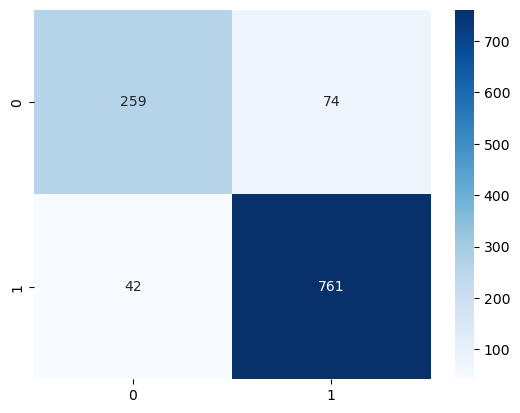

In [49]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")

# plot the confusion matrix for the best model
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)


In [50]:
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# create a function to perform cross validation
def cross_validate_models(models, X, y, cv=5):
    results = []
    for model in models:
        kfold = KFold(n_splits=cv, random_state=42, shuffle=True)
        scores = cross_val_score(model, X, y, cv=kfold)
        results.append({"model": model.__class__.__name__,
                        "mean_accuracy": np.mean(scores),
                        "std_accuracy": np.std(scores)})
    return pd.DataFrame(results)

# cross validate the models
cross_val_results = cross_validate_models(models, X, y)
cross_val_results


/opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

,model,mean_accuracy,std_accuracy
0,LogisticRegression,0.762852,0.018934
1,SVC,0.710387,0.005650
2,RandomForestClassifier,0.891725,0.006704
3,KNeighborsClassifier,0.821655,0.013689
4,DecisionTreeClassifier,0.851408,0.010787
5,XGBClassifier,0.889261,0.006759


In [51]:
# hyperparameter tuning of Best Model

from sklearn.model_selection import GridSearchCV

# Create a parameter grid for the Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Create a GridSearchCV object

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new Random Forest Classifier with the best parameters
best_rf = RandomForestClassifier(**best_params)

# Train the model
best_rf.fit(X_train, y_train)

# Evaluate the model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# roc auc
from sklearn.metrics import roc_auc_score

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


KeyboardInterrupt: 

In [ ]:
best_params

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Using MPS device
Input dimension: 132
Epoch 1/30, Training Loss: 0.7174247595625864
Epoch 1/30, Validation Loss: 0.6320416463745965
Epoch 2/30, Training Loss: 0.5994351548208318
Epoch 2/30, Validation Loss: 0.5927645828988817
Epoch 3/30, Training Loss: 0.5523978114967615
Epoch 3/30, Validation Loss: 0.5301537778642442
Epoch 4/30, Training Loss: 0.5287810249227873
Epoch 4/30, Validation Loss: 0.5107074148125119
Epoch 5/30, Training Loss: 0.5012564239367633
Epoch 5/30, Validation Loss: 0.49097537332110935
Epoch 6/30, Training Loss: 0.5027643710794584
Epoch 6/30, Validation Loss: 0.4924301356077194
Epoch 7/30, Training Loss: 0.4931478458391109
Epoch 7/30, Validation Loss: 0.4670731872320175
Epoch 8/30, Training Loss: 0.47842340612075696
Epoch 8/30, Validation Loss: 0.529673405819469
Epoch 9/30, Training Loss: 0.4868000086764215
Epoch 9/30, Validation Loss: 0.5165393153826395
Epoch 10/30, Training Loss: 0.47466712560452207
Epoch 10/30, Validation Loss: 0.4571272283792496
Epoch 11/30, Train

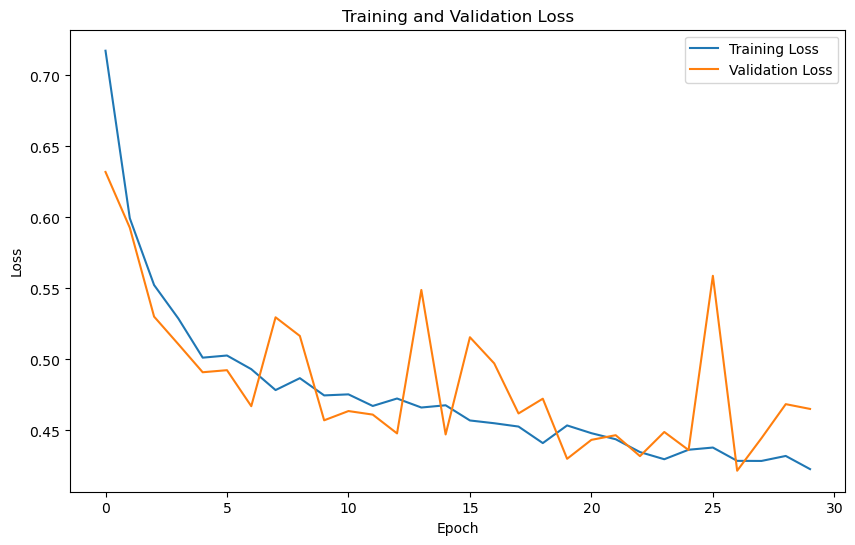

Accuracy: 0.7561619718309859
ROC AUC: 0.7440323262241071


In [56]:
# pytorch neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Set the batch size
batch_size = 64

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    

# Check if MPS is available
if torch.backends.mps.is_available():
    # Set the device to MPS
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")


# Create a neural network class for binary classification

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(64)  # Adjust to match the number of neurons
        self.dropout1 = nn.Dropout(0.3)  # Increase the dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)  # Add a new layer
        self.dropout3 = nn.Dropout(0.3)  # Add a new layer
        self.fc4 = nn.Linear(16, 1)  # Add a new layer
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))  # Add a new layer
        x = self.dropout3(x)  # Add a new layer
        x = torch.sigmoid(self.fc4(x))  # Adjust to use the new layer
        return x
        
    
# Create an instance of the neural network
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
model = NeuralNetwork(input_dim)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Train the model
# Send the model to the device
model.to(device)

# Train the model
n_epochs = 30

training_losses = []
validation_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {running_loss/len(train_loader)}")

    average_training_loss = running_loss / len(train_loader)
    training_losses.append(average_training_loss)
    
    # Evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss/len(test_loader)}")

    average_validation_loss = val_loss / len(test_loader)
    validation_losses.append(average_validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



# Evaluate the model
model.eval()
y_pred = model(X_test_tensor.to(device)).detach().cpu().numpy()

# Convert the predictions to binary
y_pred = (y_pred > 0.5).astype(int)


# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")



# Save the model
torch.save(model.state_dict(), "model.pth")


In [ ]:
Accuracy: 0.8257042253521126
ROC AUC: 0.7334619800373225


SyntaxError: invalid syntax (1313393584.py, line 2)

## Training and testing

Train, validate and test your model. Comment on the performance metrics. Note the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model. 

<details>
<summary>Note on the ROC-AUC classification metric</summary>
There is one metric we didn't cover but is used in Matbench. In binary classification models, the ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score can be used to evaluate performance. It quantifies the ability of the model to distinguish between positive and negative instances across different decision thresholds. A higher ROC-AUC score (ranging from 0.5 to 1) indicates better performance, with 1 representing a perfect classifier and 0.5 indicating performance no better than random chance. There is a more detailed discussion on https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

The metric can be calculated using the `roc_auc_score` function from the `sklearn.metrics` module, e.g.

```python
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob) 
y_true = [...]  
y_pred_prob = [...]  

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Display the result
print(f'ROC-AUC Score: {roc_auc:.4f}')
```
</details>

In [ ]:
# Spare cell




## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell




## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page. 

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).